# Data

In [1]:
import ast
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [124]:
# USDC: baseCurrency:  "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
# USDT: baseCurrency:  "0xdac17f958d2ee523a2206206994597c13d831ec7"
# quoteCurrency:  "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

# A simple function to use requests.post to make the API call.
def run_query(query):  
    headers = {'X-API-KEY': 'BQYjLXSsm32NnV6FM4eudu9xYt2L3AsW'}
    request = requests.post('https://graphql.bitquery.io/',
                            json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code,
                        query))

# The GraphQL query
query = """
query
{
  ethereum(network: ethereum) {
    dexTrades(
      options: {limit: 100000, asc: "timeInterval.minute"}
      date: {since: "2021-04-21"}
      exchangeName: {is: "Uniswap"}
      baseCurrency: {is: "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"}
      quoteCurrency: {is: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}
    ) {
      timeInterval {
        minute(count: 5)
      }
      baseCurrency {
        symbol
        address
      }
      baseAmount
      quoteCurrency {
        symbol
        address
      }
      quoteAmount
      trades: count
      quotePrice
      maximum_price: quotePrice(calculate: maximum)
      minimum_price: quotePrice(calculate: minimum)
      open_price: minimum(of: block, get: quote_price)
      close_price: maximum(of: block, get: quote_price)
    }
  }
}

"""
# Execute the query
result = run_query(query)  

#Build dataframe
data=pd.DataFrame(result['data']['ethereum']['dexTrades'])

#Data Cleaning, Feature Engineering
data= data.dropna()

time=[]
for x in range(0, data.shape[0]):
    time.append(data['timeInterval'].iloc[x]['minute'])  
data['timeInterval']= time

data['close_price']= data['close_price'].apply(lambda x: float(x))
data=data.set_index('timeInterval')
data.index=pd.to_datetime(data.index)
print(data.shape)
data.tail(2)

(10906, 10)


,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-05-28 20:50:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",492825.840711,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",202.031721,42,0.000410,0.000411,0.000407,0.00040661666183897685,0.000409
2021-05-28 20:55:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",150964.485675,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",61.810895,12,0.000409,0.000411,0.000408,0.00040874447615449116,0.000409


# Splitting

In [125]:
#test set, last 7 days test
shift= data.index[-1]+ timedelta(hours=-data.index[-1].hour ,minutes=-data.index[-1].minute , days=-6)
data.loc[shift:]

,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-05-22 00:00:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",1.458491e+06,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",598.078122,34,0.000410,0.000413,0.000408,0.0004128227668786842,0.000410
2021-05-22 00:05:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",9.540819e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",395.518088,24,0.000415,0.000417,0.000410,0.0004101696412696805,0.000417
2021-05-22 00:10:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",1.066987e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",44.186005,19,0.000414,0.000416,0.000414,0.0004141550244153279,0.000414
2021-05-22 00:15:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",4.678182e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",194.896953,30,0.000417,0.000418,0.000414,0.00041630497308516013,0.000415
2021-05-22 00:20:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",8.431584e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",350.660200,43,0.000416,0.000419,0.000413,0.00041476971736931315,0.000415
...,...,...,...,...,...,...,...,...,...,...
2021-05-28 20:35:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",5.419167e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",218.970375,46,0.000404,0.000406,0.000400,0.0004027449601982207,0.000406
2021-05-28 20:40:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",3.150607e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",127.999607,35,0.000406,0.000407,0.000403,0.00040326222937584947,0.000405
2021-05-28 20:45:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",4.855401e+05,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",197.884691,38,0.000408,0.000409,0.000405,0.00040507403616646767,0.000407


In [126]:
# train set
data.loc[:shift][:-1]

,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-04-21 00:00:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",898485.332532,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",383.485217,32,0.000427,0.000430,0.000425,0.00042839894775840634,0.000427
2021-04-21 00:05:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",405158.449595,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",173.329440,21,0.000428,0.000429,0.000425,0.00042473729624702193,0.000429
2021-04-21 00:10:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",456248.816974,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",194.422141,22,0.000426,0.000429,0.000425,0.0004289261204482108,0.000425
2021-04-21 00:15:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",194312.055620,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",82.883355,31,0.000427,0.000428,0.000425,0.0004272210601267871,0.000427
2021-04-21 00:20:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",645764.635486,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",274.081634,26,0.000424,0.000428,0.000423,0.00042776027283324337,0.000425
...,...,...,...,...,...,...,...,...,...,...
2021-05-21 23:35:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",312626.038905,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",129.514071,30,0.000414,0.000416,0.000413,0.0004128837881932394,0.000415
2021-05-21 23:40:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",260851.549533,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",108.008322,28,0.000414,0.000415,0.000412,0.0004153947152691666,0.000415
2021-05-21 23:45:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",727522.305861,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",303.841784,25,0.000418,0.000420,0.000413,0.0004129368330840445,0.000420


# Bollinger, EMA , 2Layer Model

In [127]:
# Prediction of EMA Bollinger Bands (span=20, no_of_std=2)

def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=20).mean()
    std= df['close_price'].ewm(span=20).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 2 * std).abs()
    df['bearish_upper'] = EMA +  2 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 2 * std).abs()
    df['neutral_upper'] = EMA + 2 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 2 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 2 * std
    
    df.dropna(inplace=True)
        
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


# 7 days splitting
shift= data_bands.index[-1]+ timedelta(hours=-data_bands.index[-1].hour ,minutes=-data_bands.index[-1].minute , days=-6)
#test
test_set = data_bands.loc[shift:]
# train
train_set= data_bands.loc[:shift][:-1]


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test


data_final_EMA_Bollinger_1= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_1 = Sequential()
    model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model_1.add(Dropout(0.2))
    model_1.add(Dense(units=1 ))  
    model_1.add(Activation('linear'))  
    model_1.compile(loss='mse', optimizer='adam') 

    model_1.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_1.predict(X_test).squeeze()
    
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Bollinger_1= data_final_EMA_Bollinger_1.join(predicted)

data_final_EMA_Bollinger_1;

Epoch 1/30
251/251 [==============================] - 7s 12ms/step - loss: 8.0718e-05 - val_loss: 1.9790e-04
Epoch 2/30
251/251 [==============================] - 2s 8ms/step - loss: 3.5863e-05 - val_loss: 1.5122e-04
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 2.9615e-05 - val_loss: 1.3447e-04
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 2.9555e-05 - val_loss: 1.2682e-04
Epoch 5/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8937e-05 - val_loss: 1.2566e-04
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 2.8745e-05 - val_loss: 1.2597e-04
Epoch 7/30
251/251 [==============================] - 2s 8ms/step - loss: 2.9052e-05 - val_loss: 1.2383e-04
Epoch 8/30
251/251 [==============================] - 2s 8ms/step - loss: 2.9220e-05 - val_loss: 1.2335e-04
Epoch 9/30
251/251 [==============================] - 2s 7ms/step - loss: 2.8785e-05 - val_loss: 1.2520e-04
Epoch 10/30
251/251 [======

251/251 [==============================] - 2s 8ms/step - loss: 1.9430e-06 - val_loss: 1.0908e-05
Epoch 17/30
251/251 [==============================] - 2s 8ms/step - loss: 1.9671e-06 - val_loss: 1.0367e-05
Epoch 18/30
251/251 [==============================] - 2s 9ms/step - loss: 1.8501e-06 - val_loss: 1.0250e-05
Epoch 19/30
251/251 [==============================] - 2s 9ms/step - loss: 1.7401e-06 - val_loss: 1.0254e-05
Epoch 20/30
251/251 [==============================] - 2s 7ms/step - loss: 1.9245e-06 - val_loss: 1.0097e-05
Epoch 21/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8726e-06 - val_loss: 1.0522e-05
Epoch 22/30
251/251 [==============================] - 2s 10ms/step - loss: 1.9520e-06 - val_loss: 1.0376e-05
Epoch 23/30
251/251 [==============================] - 2s 9ms/step - loss: 1.9603e-06 - val_loss: 1.0214e-05
Epoch 24/30
251/251 [==============================] - 2s 9ms/step - loss: 1.9743e-06 - val_loss: 1.0185e-05
Epoch 25/30
251/251 [=========

251/251 [==============================] - 5s 11ms/step - loss: 3.7868e-05 - val_loss: 4.1855e-05
Epoch 2/30
251/251 [==============================] - 2s 8ms/step - loss: 6.1978e-06 - val_loss: 1.6983e-05
Epoch 3/30
251/251 [==============================] - 2s 8ms/step - loss: 2.9989e-06 - val_loss: 1.4482e-05
Epoch 4/30
251/251 [==============================] - 2s 8ms/step - loss: 2.4957e-06 - val_loss: 1.1864e-05
Epoch 5/30
251/251 [==============================] - 2s 10ms/step - loss: 2.1524e-06 - val_loss: 1.0100e-05
Epoch 6/30
251/251 [==============================] - 2s 9ms/step - loss: 1.9683e-06 - val_loss: 8.7033e-06
Epoch 7/30
251/251 [==============================] - 2s 9ms/step - loss: 1.7383e-06 - val_loss: 7.7480e-06
Epoch 8/30
251/251 [==============================] - 2s 8ms/step - loss: 1.7598e-06 - val_loss: 7.1245e-06
Epoch 9/30
251/251 [==============================] - 2s 9ms/step - loss: 1.7001e-06 - val_loss: 6.4381e-06
Epoch 10/30
251/251 [================

# Non-Bollinger, EMA, 2Layer Model

In [128]:
def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['close_price'].ewm(span=2).mean()
    std= df['close_price'].ewm(span=2).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 0.9 * std).abs()
    df['bearish_upper'] = EMA +  0.9 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 0.9 * std).abs()
    df['neutral_upper'] = EMA + 0.9 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 0.9 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 0.9 * std
    
    df.dropna(inplace=True)
    
    
    df=df[['trades','close_price',
           'bearish_lower','bearish_upper', 
           'neutral_lower','neutral_upper',
           'bullish_lower','bullish_upper']]
    
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)

# 7 days splitting
shift= data_bands.index[-1]+ timedelta(hours=-data_bands.index[-1].hour ,minutes=-data_bands.index[-1].minute , days=-6)
#test
test_set = data_bands.loc[shift:]
# train
train_set= data_bands.loc[:shift][:-1]


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test



data_final_EMA_Non_Bollinger_1= test_set.copy()

for col in test_set.columns[1:]:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model_1 = Sequential()
    model_1.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model_1.add(Dropout(0.2))
    model_1.add(Dense(units=1 ))  
    model_1.add(Activation('linear'))  
    model_1.compile(loss='mse', optimizer='adam') 

    model_1.fit(X_train, y_train, validation_split=0.1, epochs = 30, batch_size = 32, verbose=1, shuffle=False)
    
    prediction=model_1.predict(X_test).squeeze()
        
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA_Non_Bollinger_1= data_final_EMA_Non_Bollinger_1.join(predicted)

data_final_EMA_Non_Bollinger_1;

Epoch 1/30
251/251 [==============================] - 6s 11ms/step - loss: 8.6551e-05 - val_loss: 1.9830e-04
Epoch 2/30
251/251 [==============================] - 2s 8ms/step - loss: 3.5027e-05 - val_loss: 1.4993e-04
Epoch 3/30
251/251 [==============================] - 2s 8ms/step - loss: 2.9734e-05 - val_loss: 1.3167e-04
Epoch 4/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8783e-05 - val_loss: 1.2817e-04
Epoch 5/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8886e-05 - val_loss: 1.2654e-04
Epoch 6/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8936e-05 - val_loss: 1.2593e-04
Epoch 7/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8595e-05 - val_loss: 1.2510e-04
Epoch 8/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8715e-05 - val_loss: 1.2397e-04
Epoch 9/30
251/251 [==============================] - 2s 8ms/step - loss: 2.8732e-05 - val_loss: 1.2447e-04
Epoch 10/30
251/251 [======

251/251 [==============================] - 2s 8ms/step - loss: 1.8343e-05 - val_loss: 8.4070e-05
Epoch 17/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8984e-05 - val_loss: 8.4987e-05
Epoch 18/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8333e-05 - val_loss: 8.3487e-05
Epoch 19/30
251/251 [==============================] - 2s 9ms/step - loss: 1.8375e-05 - val_loss: 8.4049e-05
Epoch 20/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8150e-05 - val_loss: 8.4214e-05
Epoch 21/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8221e-05 - val_loss: 8.2807e-05
Epoch 22/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8263e-05 - val_loss: 8.1897e-05
Epoch 23/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8224e-05 - val_loss: 8.3389e-05
Epoch 24/30
251/251 [==============================] - 2s 8ms/step - loss: 1.7957e-05 - val_loss: 8.3841e-05
Epoch 25/30
251/251 [==========

251/251 [==============================] - 6s 11ms/step - loss: 7.0329e-05 - val_loss: 1.4838e-04
Epoch 2/30
251/251 [==============================] - 2s 9ms/step - loss: 2.4904e-05 - val_loss: 9.9631e-05
Epoch 3/30
251/251 [==============================] - 2s 8ms/step - loss: 1.8158e-05 - val_loss: 7.9737e-05
Epoch 4/30
251/251 [==============================] - 2s 8ms/step - loss: 1.6056e-05 - val_loss: 7.1942e-05
Epoch 5/30
251/251 [==============================] - 2s 8ms/step - loss: 1.5635e-05 - val_loss: 6.9681e-05
Epoch 6/30
251/251 [==============================] - 2s 8ms/step - loss: 1.5633e-05 - val_loss: 6.7940e-05
Epoch 7/30
251/251 [==============================] - 2s 8ms/step - loss: 1.5598e-05 - val_loss: 6.6766e-05
Epoch 8/30
251/251 [==============================] - 2s 8ms/step - loss: 1.5723e-05 - val_loss: 6.6751e-05
Epoch 9/30
251/251 [==============================] - 2s 8ms/step - loss: 1.5535e-05 - val_loss: 6.9210e-05
Epoch 10/30
251/251 [=================

# Comparing Bollinger & Non-Bollinger Bands & Revenues

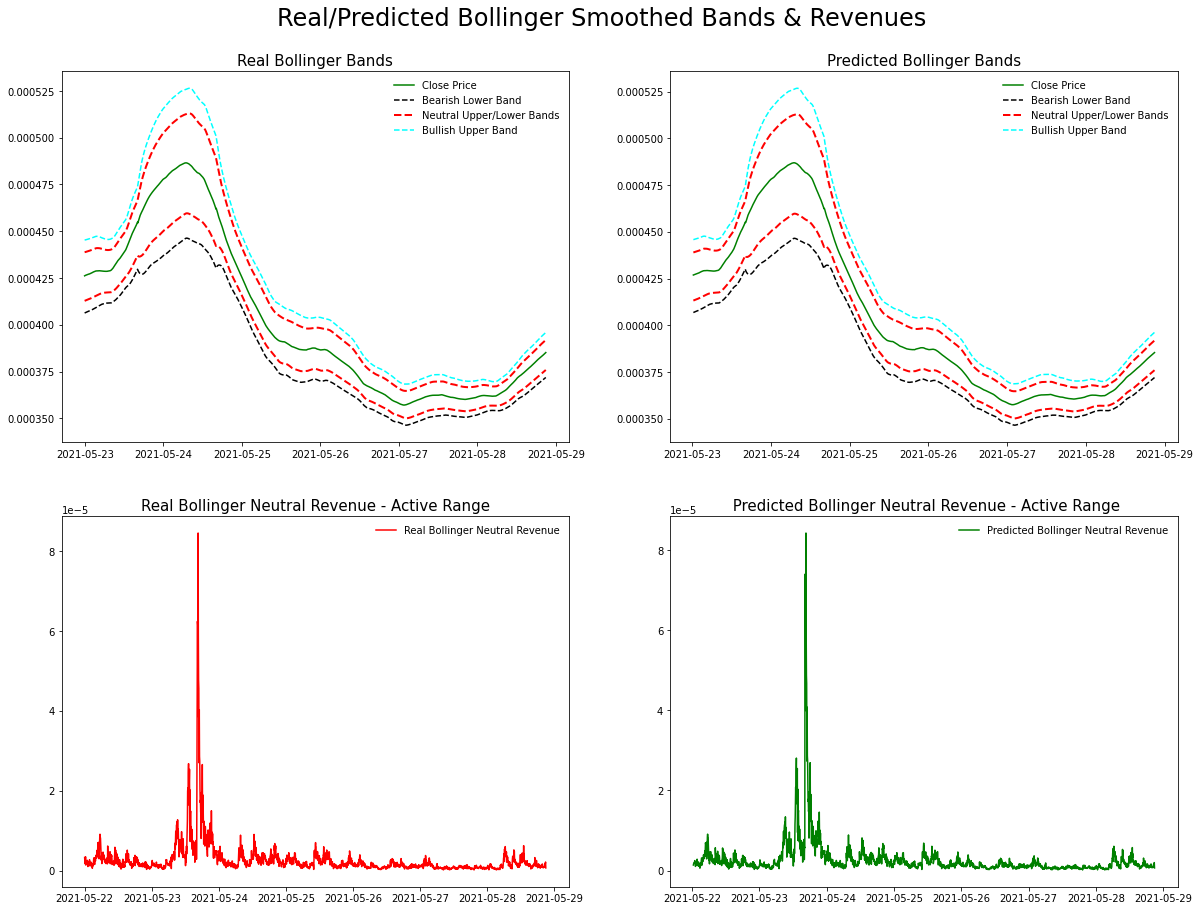

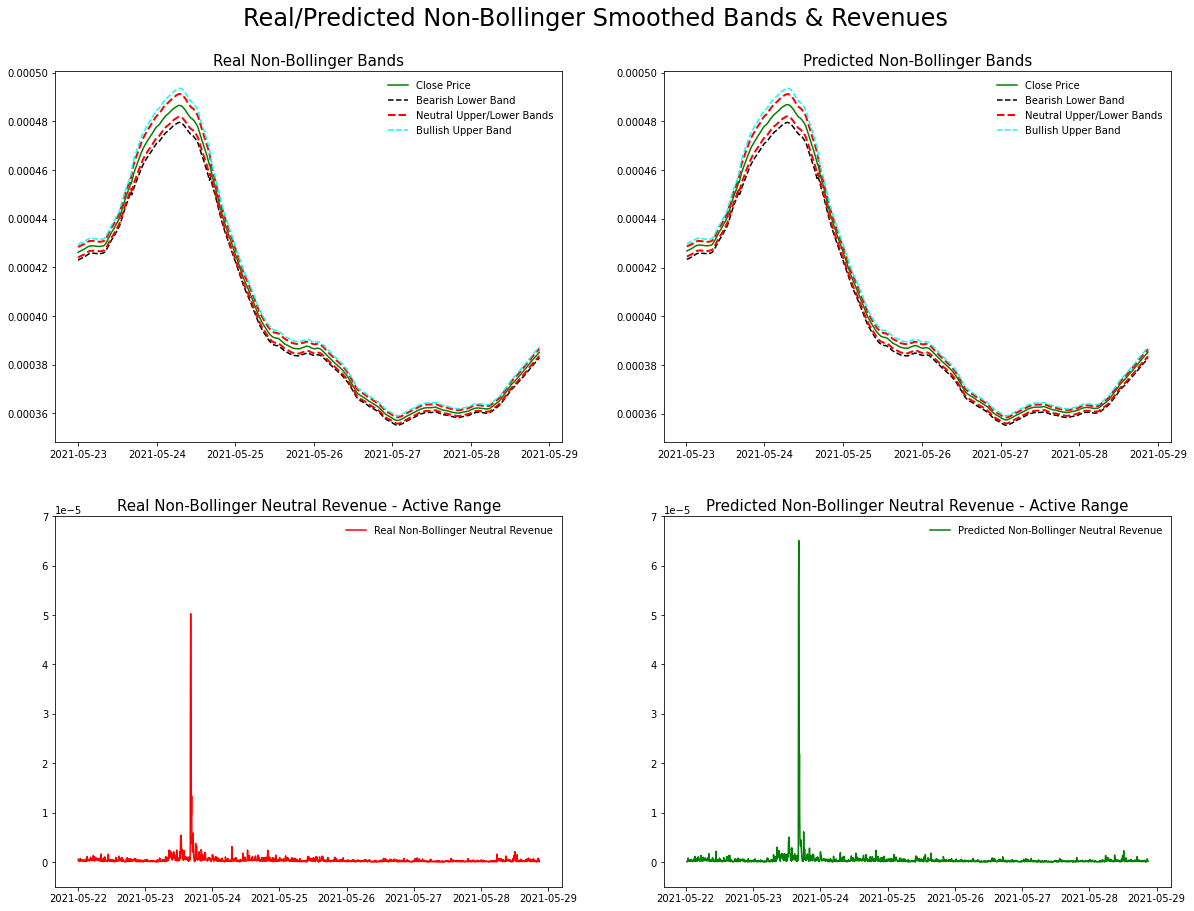

In [129]:
############Bollinger############
test_EMA_Bollinger_1=data_final_EMA_Bollinger_1.copy()

plt.figure(figsize=(20,15))
#Daily Smoothed Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Bollinger_1['close_price'].rolling(window=12*24).mean(), label="Close Price", color='g')
plt.plot(test_EMA_Bollinger_1['bearish_lower'].rolling(window=12*24).mean(), "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['neutral_lower'].rolling(window=12*24).mean(), "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['neutral_upper'].rolling(window=12*24).mean(), "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Bollinger_1['bullish_upper'].rolling(window=12*24).mean(), "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Bollinger Bands', fontsize=15)


#Daily Smoothed Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Bollinger_1['predicted_close_price'].rolling(window=12*24).mean(), label="Close Price", color='g' )
plt.plot(test_EMA_Bollinger_1['predicted_bearish_lower'].rolling(window=12*24).mean(), "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Bollinger_1['predicted_neutral_lower'].rolling(window=12*24).mean(), "r--", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_neutral_upper'].rolling(window=12*24).mean(), "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Bollinger_1['predicted_bullish_upper'].rolling(window=12*24).mean(), "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Bollinger Bands', fontsize=15)


#Real Bollinger Neutral Revenue (In Active Range)
plt.subplot(2,2,3)
time_revenue_real_bollinger = []
total_revenue_real_bollinger=[]

for x in range (0, test_EMA_Bollinger_1.shape[0]):
    if (test_EMA_Bollinger_1.iloc[x,1] >= test_EMA_Bollinger_1.iloc[x,4]) & (test_EMA_Bollinger_1.iloc[x,1] <= test_EMA_Bollinger_1.iloc[x,5]):
        time_revenue_real_bollinger.append(test_EMA_Bollinger_1.index[x]) 
        revenue= 0.003* (test_EMA_Bollinger_1.iloc[x,5] - test_EMA_Bollinger_1.iloc[x,4]) * test_EMA_Bollinger_1.iloc[x,0]  
        total_revenue_real_bollinger.append(revenue)

plt.plot(time_revenue_real_bollinger, total_revenue_real_bollinger, label="Real Bollinger Neutral Revenue", color='r')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Bollinger Neutral Revenue - Active Range', fontsize=15)


#Predicted Bollinger Neutral Revenue (In Active Range)
plt.subplot(2,2,4)
time_revenue_predicted_bollinger = []
total_revenue_predicted_bollinger=[]
for x in range (0, test_EMA_Bollinger_1.shape[0]):
    if (test_EMA_Bollinger_1.iloc[x,8] >= test_EMA_Bollinger_1.iloc[x,11]) & (test_EMA_Bollinger_1.iloc[x,8] <= test_EMA_Bollinger_1.iloc[x,12]):
        time_revenue_predicted_bollinger.append(test_EMA_Bollinger_1.index[x]) 
        revenue= 0.003* (test_EMA_Bollinger_1.iloc[x,12] - test_EMA_Bollinger_1.iloc[x,11]) * test_EMA_Bollinger_1.iloc[x,0]  
        total_revenue_predicted_bollinger.append(revenue) 
        
plt.plot(time_revenue_predicted_bollinger,total_revenue_predicted_bollinger, label="Predicted Bollinger Neutral Revenue", color='g')
plt.legend(loc= 'upper right', frameon=False)
plt.title(' Predicted Bollinger Neutral Revenue - Active Range', fontsize=15)

plt.suptitle('Real/Predicted Bollinger Smoothed Bands & Revenues',y=0.94,fontsize=24)
plt.show()

############NonBollinger############
test_EMA_Non_Bollinger_1=data_final_EMA_Non_Bollinger_1.copy()


plt.figure(figsize=(20,15))
#Daily Smoothed Real Bands
plt.subplot(2,2,1)
plt.plot(test_EMA_Non_Bollinger_1['close_price'].rolling(window=12*24).mean(), label="Close Price", color='g')
plt.plot(test_EMA_Non_Bollinger_1['bearish_lower'].rolling(window=12*24).mean(), "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['neutral_lower'].rolling(window=12*24).mean(), "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['neutral_upper'].rolling(window=12*24).mean(), "r--", label="Neutral Upper/Lower Bands", color='r',lw=2)
plt.plot(test_EMA_Non_Bollinger_1['bullish_upper'].rolling(window=12*24).mean(), "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Real Non-Bollinger Bands', fontsize=15)


#Daily Smoothed Predicted Bands
plt.subplot(2,2,2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_close_price'].rolling(window=12*24).mean(), label="Close Price", color='g' )
plt.plot(test_EMA_Non_Bollinger_1['predicted_bearish_lower'].rolling(window=12*24).mean(), "r--", label="Bearish Lower Band", color='black')
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_lower'].rolling(window=12*24).mean(), "r--", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_neutral_upper'].rolling(window=12*24).mean(), "r--", label="Neutral Upper/Lower Bands", color='r', lw=2)
plt.plot(test_EMA_Non_Bollinger_1['predicted_bullish_upper'].rolling(window=12*24).mean(), "r--", label="Bullish Upper Band", color='cyan')
plt.legend(loc= 'upper right', frameon=False)
plt.title('Predicted Non-Bollinger Bands', fontsize=15)


# Real Bollinger Neutral Revenue (In Active Range)
plt.subplot(2,2,3)
time_revenue_real_nonbollinger = []
total_revenue_real_nonbollinger=[]

for x in range (0, test_EMA_Non_Bollinger_1.shape[0]):
    if (test_EMA_Non_Bollinger_1.iloc[x,1] >= test_EMA_Non_Bollinger_1.iloc[x,4]) & (test_EMA_Non_Bollinger_1.iloc[x,1] <= test_EMA_Non_Bollinger_1.iloc[x,5]):
        time_revenue_real_nonbollinger.append(test_EMA_Non_Bollinger_1.index[x]) 
        revenue= 0.003* (test_EMA_Non_Bollinger_1.iloc[x,5] - test_EMA_Non_Bollinger_1.iloc[x,4]) * test_EMA_Non_Bollinger_1.iloc[x,0]  
        total_revenue_real_nonbollinger.append(revenue)

plt.plot(time_revenue_real_nonbollinger, total_revenue_real_nonbollinger, label="Real Non-Bollinger Neutral Revenue", color='r')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(-0.000005,7E-5)
plt.title('Real Non-Bollinger Neutral Revenue - Active Range', fontsize=15)


# Predicted Bollinger Neutral Revenue (In Active Range)
plt.subplot(2,2,4)
time_revenue_predicted_nonbollinger = []
total_revenue_predicted_nonbollinger=[]
for x in range (0, test_EMA_Non_Bollinger_1.shape[0]):
    if (test_EMA_Non_Bollinger_1.iloc[x,8] >= test_EMA_Non_Bollinger_1.iloc[x,11]) & (test_EMA_Non_Bollinger_1.iloc[x,8] <= test_EMA_Non_Bollinger_1.iloc[x,12]):
        time_revenue_predicted_nonbollinger.append(test_EMA_Non_Bollinger_1.index[x]) 
        revenue= 0.003* (test_EMA_Non_Bollinger_1.iloc[x,12] - test_EMA_Non_Bollinger_1.iloc[x,11]) * test_EMA_Non_Bollinger_1.iloc[x,0]  
        total_revenue_predicted_nonbollinger.append(revenue) 
        
plt.plot(time_revenue_predicted_nonbollinger,total_revenue_predicted_nonbollinger, label="Predicted Non-Bollinger Neutral Revenue", color='g')
plt.legend(loc= 'upper right', frameon=False)
plt.ylim(-0.000005,7E-5)
plt.title('Predicted Non-Bollinger Neutral Revenue - Active Range', fontsize=15)

plt.suptitle('Real/Predicted Non-Bollinger Smoothed Bands & Revenues',y=0.94,fontsize=24)
plt.show()

In [130]:
print('Total Revenue Real Neutral Bollinger=', sum(total_revenue_real_bollinger))       
print('Total Revenue Predicted Neutral Bollinger=', sum(total_revenue_predicted_bollinger))
print('Neutral Bollinger Revenues Prediction Score= ', metrics.r2_score(0.003* (test_EMA_Bollinger_1.dropna()['neutral_upper'] - test_EMA_Bollinger_1.dropna()['neutral_lower']) *test_EMA_Bollinger_1.dropna()['trades'],
                   0.003* (test_EMA_Bollinger_1.dropna()['predicted_neutral_upper'] - test_EMA_Bollinger_1.dropna()['predicted_neutral_lower'])*test_EMA_Non_Bollinger_1.dropna()['trades']))

print('\n')

print('Total Revenue Real Neutral Nonbollinger=', sum(total_revenue_real_nonbollinger))       
print('Total Revenue Predicted Neutral Nonbollinger=', sum(total_revenue_predicted_nonbollinger))
print('Neutral NonBollinger Revenues Prediction Score= ',
       metrics.r2_score(0.003* (test_EMA_Non_Bollinger_1.dropna()['neutral_upper'] - test_EMA_Non_Bollinger_1.dropna()['neutral_lower']) *test_EMA_Non_Bollinger_1.dropna()['trades'],
                    0.003* (test_EMA_Non_Bollinger_1.dropna()['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1.dropna()['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1.dropna()['trades']))

Total Revenue Real Neutral Bollinger= 0.0052389626342925774
Total Revenue Predicted Neutral Bollinger= 0.005295877185677392
Neutral Bollinger Revenues Prediction Score=  0.9607804778573075


Total Revenue Real Neutral Nonbollinger= 0.0009548771188914686
Total Revenue Predicted Neutral Nonbollinger= 0.0009463610772068228
Neutral NonBollinger Revenues Prediction Score=  0.6509523833117636


# Revenues & Prediction Score

In [131]:
pd.DataFrame({'Real Total Neutral Revenue':[sum(total_revenue_real_bollinger),sum(total_revenue_real_nonbollinger)],
              'Predicted Total Neutral Revenue':[sum(total_revenue_predicted_bollinger),sum(total_revenue_predicted_nonbollinger)],
              'Prediction Score': [metrics.r2_score(0.003* (test_EMA_Bollinger_1.dropna()['neutral_upper'] - test_EMA_Bollinger_1.dropna()['neutral_lower']) *test_EMA_Bollinger_1.dropna()['trades'],
                   0.003* (test_EMA_Bollinger_1.dropna()['predicted_neutral_upper'] - test_EMA_Bollinger_1.dropna()['predicted_neutral_lower'])*test_EMA_Non_Bollinger_1.dropna()['trades']),
                   metrics.r2_score(0.003* (test_EMA_Non_Bollinger_1.dropna()['neutral_upper'] - test_EMA_Non_Bollinger_1.dropna()['neutral_lower']) *test_EMA_Non_Bollinger_1.dropna()['trades'],
                    0.003* (test_EMA_Non_Bollinger_1.dropna()['predicted_neutral_upper'] - test_EMA_Non_Bollinger_1.dropna()['predicted_neutral_lower']) *test_EMA_Non_Bollinger_1.dropna()['trades'])]
              },index=['Bollinger', 'NonBollinger'])

,Real Total Neutral Revenue,Predicted Total Neutral Revenue,Prediction Score
Bollinger,0.005239,0.005296,0.960780
NonBollinger,0.000955,0.000946,0.650952


In [132]:
invested_money=10000
print('invested = $', invested_money)

print('Real_Bollinger_Revenue= ', 0.005198 *10000)
print('Predicted_Bollinger_Revenue= ', 0.005301 *10000)

print('Real_NonBollinger_Revenue= ', 0.000945 *10000)
print('Predicted_NonBollinger_Revenue= ', 0.000953 *10000)

invested = $ 10000
Real_Bollinger_Revenue=  51.980000000000004
Predicted_Bollinger_Revenue=  53.010000000000005
Real_NonBollinger_Revenue=  9.45
Predicted_NonBollinger_Revenue=  9.53


# Conclusion

1. The last 7 days of the data was used as the test set to evaluate the performance of the simple 2layer LSTM model.


2. To display the whole 7-day test set in a graph, smoothing based on daily rolling mean was added.


2. The score of the LSTM model for predicting revenue based on bollinger bands were higher than that of nonbollinger bands. 


3. Total revenues estimated for real/predicted bollinger bands are larger than those fore real/predicted nonbollinger bands.